In [1]:
%matplotlib inline

# TF-IDF + SVM 을 이용한 News Sentiment 분석
## Process
1. 미리 Preprocessing된 데이터를 읽어
2. 데이터를 TF-IDF로 임베딩
3. TRAIN-TEST 데이터 분리
4. SVM으로 TRAIN 학습
5. TEST 검증
6. 최적의 k값 찾기

## Reference
- [Word Embedding Explained, a comparison and code tutorial](https://medium.com/@dcameronsteinke/tf-idf-vs-word-embedding-a-comparison-and-code-tutorial-5ba341379ab0)
- [Scikit-Learn의 문서 전처리 기능](https://datascienceschool.net/view-notebook/3e7aadbf88ed4f0d87a76f9ddc925d69/)
- [서포트 벡터 머신](https://datascienceschool.net/view-notebook/6c6d450cb2ee49558856fd924b326e00/)

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [3]:
# 데이터 불러옴
data = pd.read_json("../data/news_reactions_recent_preprocessed.json")
data.head()

,title_token,content_token,reaction_category
0,"[전두환, 프로젝트, 연희동, 집, 가구, 세트, 막대, 세금, 구입, 네이버, 뉴스]","[대통령, 자리, 물러난, 전두환, 별도, 전직, 대통령, 사무실, 내지, 않았으면...",1
1,"[식약처, 존슨, 앤드, 존슨, 제품, 빼고, 암, 위험, 인공, 유방, 퇴, 출,...","[식품의약품안전처, 암, 발병, 사례, 보고, 된, 인공, 유방, 보, 형, 물이,...",1
10,"[늘어나는, 주택연금, 가입자, 집, 한, 채, 있다면, 노후, 걱정, 마세요, 네...","[주택연금, 올, 들어서만, 명, 가입, 정부, 주택연금, 가입, 기준, 완화, 예...",2
100,"[비서, 성폭행, 안희정, 심, 달랐던, 판단, 오늘, 대법, 선고, 네이버, 뉴스]","[앵커, 심, 무죄, 나왔지만, 심, 실형, 선고, 받고, 법정구속, 돼, 있습니다...",1
1000,"[인천, 경기, 북부, 호우, 주의보, 내일, 최고, 더, 온다, 네이버, 뉴스]","[아침, 인천, 경기, 북부, 파주, 고양, 연천, 김포, 안산, 호우, 주의보, ...",2


## Vectorization
Scikit-Learn의 TfidVectorizer를 이용해서 TF-IDF 임베딩을 수행함

In [94]:
# sizes: 512, 1024, 2048, 5096, 10192, 20384
MAX_FEATURE = 5096
# l1, l2(default)
NORM = 'l1'
title_vectorizer = TfidfVectorizer (max_features=MAX_FEATURE, norm=NORM)
content_vectorizer = TfidfVectorizer (max_features=MAX_FEATURE, norm=NORM)

In [95]:
%%time 
title_corpus = data.title_token.map(lambda x: " ".join(x))
title_vectorizer.fit(title_corpus)

CPU times: user 93.3 ms, sys: 48 ms, total: 141 ms
Wall time: 147 ms


In [96]:
%%time
content_corpus = data.content_token.map(lambda x: " ".join(x))
content_vectorizer.fit(content_corpus)

CPU times: user 1.2 s, sys: 143 ms, total: 1.34 s
Wall time: 1.53 s


위에서 생성한 Vectorizer를 이용해서 문장 내의 토큰들을 TF-IDF 벡터로 변환한다.
그러면 한 뉴스 문서는 TF-IDF 벡터들의 목록이므로 2차원 배열이 됨.

In [97]:
%%time 
TITLE_MAX_LEN = 32
CONTENT_MAX_LEN = 512
# title_X = data.title_token.map(lambda x: title_vectorizer.transform(x if len(x) <= TITLE_MAX_LEN else x[:TITLE_MAX_LEN]))
# content_X = data.title_token.map(lambda x: content_vectorizer.transform(x if len(x) <= CONTENT_MAX_LEN else x[:CONTENT_MAX_LEN]))
title_X = title_vectorizer.transform(title_corpus)
content_X = content_vectorizer.transform(content_corpus)

CPU times: user 984 ms, sys: 34.3 ms, total: 1.02 s
Wall time: 1.08 s


In [98]:
print(title_corpus[0], len(title_corpus[0]), title_X[0], title_X[0].shape)
print(content_corpus[0], len(content_corpus[0]), content_X[0], title_X[0].shape)

전두환 프로젝트 연희동 집 가구 세트 막대 세금 구입 네이버 뉴스 36   (0, 4661)	0.12653278104328083
  (0, 3508)	0.1465336874278461
  (0, 2338)	0.1391519479797004
  (0, 2329)	0.1391519479797004
  (0, 1761)	0.1465336874278461
  (0, 1182)	0.018205609559322475
  (0, 1087)	0.018205609559322475
  (0, 657)	0.1391519479797004
  (0, 126)	0.12653278104328083 (1, 5096)
대통령 자리 물러난 전두환 별도 전직 대통령 사무실 내지 않았으면서도 사무실 임차보증금 월세 등 명목 정부 원금 받아 간 사실 문서 확인 됐다 또 퇴임 후 서울 서대문구 연희동 집 돌아간 전두환 막대 세금 각종 고급 가구 등 구입 해 자신 집 꾸민 사실 드러났다 뉴스타파 행정안전부 제출 받은 전직 대통령 예 우 관련 더미 이 같은 사실 보여주는 정부 문서 찾아냈다 뉴스타파 확인 문서 총무처 현 행정안전부 생산 된 것 문서 따르면 전두환 퇴임 후 본인 집 사무실 차리겠다며 임차보증금 원 월세 관리 비조 매달 원 정도 정부 받아 챙겼다 자기 집 자신 세 놓는 형태 나랏돈 빼 먹은 것 뉴스타파 행정안전부 정보공개 청구 해 작성 된 전직 대통령 예 우 관련 문서 확보 했다 전직 대통령 전두환 지급 된 역 확인 하기 위 해서다 뉴스타파 입수 문서 지금 행정안전부 해당 하는 총무처 만든 것 작성 당시 총무처 장관 이었던 김용갑 씨 결재 문서 군인 출신 김용갑 씨 전두환 정부 민정 수석 지낸 뒤 노태우 정부 총무처 장관 지냈다 총무처 문서 전두환 퇴임 직후 정부 지원 받은 내 역 빼곡 히 들어있다 그 중 사무 집기 항목 보면 책상 원 의자 원 응접실 세트 원 가 들어 있고 심지어 옷 걸이 기정 화기 시계 정부 예산 사들인 것 나온다 이런 식 전두환 자신 연희동 집 꾸미는 데 사용 예산 당

In [99]:
print(title_X.shape)
print(content_X.shape)
# sparse matrix로 결과가 나오는 모습이다
# print(title_X[0].shape)
# print(title_X[0].toarray())
# print(content_X[0].shape)
# print(content_X[0].toarray())

(2302, 5096)
(2302, 5096)


In [100]:
y = data.reaction_category
print(len(y), y[:5])

2302 0       1
1       1
10      2
100     1
1000    2
Name: reaction_category, dtype: int64


In [101]:
%%time 
# add padding and merge title and content
def add_padding(x, min_size):
    if len(x) <= min_size:
#         pad = np.zeros((min_size - len(x), x.shape[1]), dtype=float)
#         return np.concatenate([x, pad], axis=0)
        pad = np.pad(x, (0, min_size - len(x)), mode='constant', constant_values=0)
    elif len(x) > min_size:
        return x[:min_size]
    return x

# a = title_X[0]
# r = add_padding(a.toarray(), TITLE_MAX_LEN)
# print(r)
# print(r.shape)
title_X_pad = [add_padding(x.toarray(), TITLE_MAX_LEN) for x in title_X]
content_X_pad = [add_padding(x.toarray(), CONTENT_MAX_LEN) for x in content_X]

CPU times: user 46.6 s, sys: 19.5 s, total: 1min 6s
Wall time: 1min 15s


In [102]:
title_X = np.array(title_X_pad)
content_X = np.array(content_X_pad)
print(title_X[1])

[[0. 0. 0. ... 0. 0. 0.]]


In [103]:
# 뉴스 제목이랑 뉴스 내용이랑 합친다.
X = [np.concatenate([title, content], axis=1)[0] for title, content in zip(title_X, content_X)]

In [104]:
# Shape check
print(len(X))
print(X[0], X[0].shape)

2302
[0. 0. 0. ... 0. 0. 0.] (10192,)


## 학습하기
sklearn.svm.SVM을 이용한다.


In [105]:
# Scikit Learn은 학습데이터가 2d array여야해서 강제로 변경
nsamples = len(X)
nx, ny = X[0].shape
X = np.reshape(X, (nsamples, nx*ny))

ValueError: not enough values to unpack (expected 2, got 1)

In [106]:
# 학습, 실험 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

이제 SVC를 이용해서 학습한다.

In [107]:
%%time 
C = 1
model = LinearSVC(verbose=1, C=C)
model.fit(X_train, y_train)

[LibLinear]CPU times: user 320 ms, sys: 298 ms, total: 618 ms
Wall time: 831 ms


score() 함수를 이용해서 평가한다.

In [108]:
model.score(X_train, y_train)

0.9299293862031505

In [109]:
model.score(X_test, y_test)

0.6984815618221258

Test 결과의 몇개 예시를 만들어본다

In [110]:
test_i = [0, 10, 50, 100, 150]
sentiment = ["긍정", "부정", "중립"]
for i in test_i:
    x = X_test[i]
    y = model.predict([x])[0]
    print(data.loc[i])
    print("Predict:", sentiment[y])
    print("Answer:", sentiment[y_test.values[i]])
    print()

title_token           [전두환, 프로젝트, 연희동, 집, 가구, 세트, 막대, 세금, 구입, 네이버, 뉴스]
content_token        [대통령, 자리, 물러난, 전두환, 별도, 전직, 대통령, 사무실, 내지, 않았으면...
reaction_category                                                    1
Name: 0, dtype: object
Predict: 중립
Answer: 부정

title_token          [늘어나는, 주택연금, 가입자, 집, 한, 채, 있다면, 노후, 걱정, 마세요, 네...
content_token        [주택연금, 올, 들어서만, 명, 가입, 정부, 주택연금, 가입, 기준, 완화, 예...
reaction_category                                                    2
Name: 10, dtype: object
Predict: 부정
Answer: 부정

title_token                    [검찰, 없는, 컬러, 표창장, 박지원, 입수, 경로, 네이버, 뉴스]
content_token        [꿈, 담는, 캔버스, 채널, A, CHANNEL, A, 무단, 재, 및, 재, 배...
reaction_category                                                    1
Name: 50, dtype: object
Predict: 중립
Answer: 중립

title_token            [비서, 성폭행, 안희정, 심, 달랐던, 판단, 오늘, 대법, 선고, 네이버, 뉴스]
content_token        [앵커, 심, 무죄, 나왔지만, 심, 실형, 선고, 받고, 법정구속, 돼, 있습니다...
reaction_category                                                    1
Name:

In [65]:
# 결과 모델을 pickle 파일로 저장합니다.
import pickle
from datetime import datetime
t = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
pickle.dump(model, open(f"../model/tfidf_svm_{t}.pickle", "wb"))

In [58]:
scores = []
for i in range(100):
    C = 0.001 + i / 100
    model = LinearSVC(verbose=1, max_iter=1000, C=C)
    model.fit(X_train, y_train)
    scores.append((C, model.score(X_test, y_test)))

[LibLinear][LibLinear][LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear]

/Users/heegyukim/.pyenv/versions/bitbyte-text/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

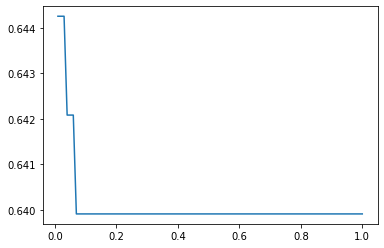

In [61]:
s_x = [x[0] for x in scores]
s_y = [x[1] for x in scores]
plt.plot(s_x, s_y)
plt.show()

In [62]:
pd.DataFrame(scores).to_csv(f"../data/tfidf_C_{C}_numfeature_{MAX_FEATURE}_norm_{NORM}.csv")